# Descrição do Problema:
O problema consiste em identificar e extrair todas informações presentes em uma partitura, sendo elas:
- Clave da partitura, dividida entre 3 possibilidades sendo elas:
    - Clave de Sol (G)
    - Clave de Fá (F)
    - Clave de Dó (C)
- Notas, essas tem sua identificação dependendo da posição em que estão sobre ou entre as linhas de uma partitura. Como a figura abaixo representa, aprovetando e colocando a notação com as claves.
    <img src="imagesnb/Claves.png">

- Figuras/Símbolos musicais: essas são as representações de duração de uma nota dentro de um compasso, sendo divididas em:
    - Semibreve
    - Mínima
    - Semínima
    - Colcheia
    - Semicolcheia
    - Fusa
    - Semifusa
    - A figura abaixo apresenta esses símbolos/figuras ordenadas da forma apresentada acima.
    <img src="imagesnb/Music_notes.png">

- Figuras/Símbolos de pausas: essas são as representações para as pausas, ou seja, momentos de silêncio em uma música, tem a mesma divisão de tempos para as figuras musicais, apresentada na figura abaixo.
    <img src="imagesnb/Music_rests.png">

# Metodologia:
Após definido o que deve-se reconhecer em uma partitura parte-se para a metodologia que será utilizada para o projeto, após obtenção da imagem a ser processada as atividades serão divididas em:
- Conversão para tons de cinza;
- Aplicação de filtros caso a imagem tenha uma qualidade inferior;
- Limiarização e segmentação: deve-se escolher algum método adequado para isso;
- Morfologia: isolar elementos pela sua forma;
- Classificação: definir o que cada elementos isolado pela morfologia é;
- Organizar a ordem que cada símbolo aparece;

# Bibliotecas a serem utilizadas:

In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
from statistics import mean, median
from math import sin, cos, pi, sqrt, ceil, floor, fabs
from random import randint

## 1. Importando a imagem

In [2]:
path = "data/1.png"
image = cv2.imread(path)

### Funções úteis: 

In [18]:
def display(image, title, gray=0):
    plt.figure(figsize=(50,50))
    
    if gray==0:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap = 'gray')  
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=40)
    plt.title(title, fontsize=50)
    plt.show()

def displayWin(image, window_name):
    cv2.imshow(window_name, image)
    cv2.waitKey()
    cv2.destroyAllWindows()
    
def graycolor(image,display=0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if display:
        plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY))
        plt.show()
    return gray
def binarize(img):
    return cv2.Canny(img, 50, 150)
def detectStaffLines(binImg):
	"""Detecta os pontos de início de cada linha de pauta das várias pautas de uma partitura.
	Retorna um vetor com cada pauta e onde (x, y) suas linhas de pauta começam."""

	""" Passo 0: realizar erosão e dilatação da imagem binária para obter seu aspecto horizontal """
	hor = binImg.copy()					#hor irá armazena uma imagem com o aspecto das linhas horizontais de binImg
	horSize = int(hor.shape[1]/100)		#define o tamanho do elemento estruturante (nº colunas/100)

	horStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horSize, 1))	#define o elemento estruturante (um segmento de reta horizontal)
	hor = cv2.erode(hor, horStructure, (-1, -1))							#realiza a erosão na imagem que contém as bordas
	hor = cv2.dilate(hor, horStructure, (-1, -1))							#realiza dilatação na imagem erodida
	
	h, w = hor.shape[:2]					#obtém dimensões da imagem
	c = hor.copy()							#cria uma imagem de backup para poder desenhar informações úteis nela
	c = cv2.cvtColor(c, cv2.COLOR_GRAY2BGR)	#transforma a imagem de tons de cinza para colorida (BGR)
	
	""" Passo 1: detectar as linhas de pauta candidatas (LPCs) """
	threshLine = w/3	#threshold para considerar uma linha de imagem (LI) como linha de pauta (LP)
	#^o threshold assume que a largura das pautas é, pelo menos, maior que 1 terço da largura da imagem
	lineSizes = []		#lista de tamanhos (número de pixels brancos) das LPCs
	lineIdxs = []		#lista de índices das LPCs na imagem original (hor)
	diffs = []			#lista de tamanhos dos gaps (vãos) entre LPCs sucessivas
	idxLPC = 0			#índice da última LPC detectada 
	for x in range(0, h):				#para todas as LIs da imagem original
		cnt = np.count_nonzero(hor[x])	#conta pixels brancos (não-nulos) da LI x
		if (cnt >= threshLine):			#se o número de pixels brancos é maior que o threshold de linhas, então a LI x é considerada uma LPC i
			lineSizes.append(cnt)		#armazena tamanho da LPC i na lista de tamanhos
			lineIdxs.append(x)			#armazena índice da LPC i na lista de índices
			if (idxLPC != 0):			#exceto para a primeira LI
				diffs.append(lineIdxs[idxLPC] - lineIdxs[idxLPC-1])	#calcula o gap entre as duas últimas LPCs detectadas
			idxLPC += 1					#avança o índice de LPCs

	nLPCs = idxLPC		#no final do passo 1, a variável idxLPC contém o número de LPCs
	if (nLPCs < 5):		#se o número de LPCs é menor que o número mínimo de linhas para se ter uma pauta (5)
		return None, -1	#então, nenhuma pauta foi detectada
	
	""" Passo 2: detectar a distância (gap) entre as LPCs """
	mini = np.amin(diffs)	#obtém a mínima distância entre LPCs sucessivas
	maxi = np.amax(diffs)	#obtém a máxima distância entre LPCs sucessivas
	
	if (nLPCs >= 20):							#se a variância dos gaps é alta, então é provável que a partitura tenha mais de uma pauta
		threshGap = int(mini + (maxi/3))	#threshGap é o threshold para considerar uma distância de LPCs sucessivas como sendo um espaço entre pautas
		#^o threshold assume que o gap entre as pautas é a menor distância entre LPCs sucessivas + um terço da maior distância entre LPCs sucessivas
	else:									#se a variância dos gaps é baixa, então é provável que a partitura tenha apenas uma pauta
		threshGap = maxi+1					#o threshold atribuido é para garantir que apenas uma pauta será detectada nos próximos passos
	
	""" Passo 3: detectar onde as LPs começam no eixo y. """
	b = 0		#índice, na lista de índices das LPCs, do começo (begin) da última LP detectada
	nStaves = 0	#o atual número de pautas detectadas
	staves = []	#lista de pautas, contendo para cada pauta as informações sobre os 5 pontos de início de cada LP  

	for x in range(1, nLPCs):							#para todas as possíveis linhas de pauta (LPCs)
		if ((lineIdxs[x] - lineIdxs[x-1] >= threshGap) or x == nLPCs-1):	#verifica se o espaço entre uma LPC e outra pode ser considerado um espaço de pautas
			if (x == nLPCs-1):							#este if garante que a última pauta será detectada
				x = nLPCs;
			
			nStaves = nStaves + 1						#ao entrar neste if, uma nova pauta foi detectada
			d = (lineIdxs[x-1] - lineIdxs[b])/4			#calcula-se então a distância entre as linhas de uma pauta
			#abaixo, calcula-se os pontos de início (apenas o y) das 5 linhas da pauta recém-detectada
			staves.append(([0, lineIdxs[b]], [0, lineIdxs[b]+d], [0, lineIdxs[b]+2*d], [0, lineIdxs[b]+3*d], [0, lineIdxs[x-1]]))
			b = x										#por fim, a próxima pauta começa onde a última terminou
	
	""" Passo 4: detectar onde as LPs começam no eixo x """
	for s in range(0, nStaves):			#para cada pauta s detectada
		for j in range(0, w):			#para todas as colunas j da imagem original no eixo x
			b = staves[s][0][1]			#b é a linha onde começa a pauta s
			e = staves[s][4][1]			#e é a linha onde termina a pauta s
			cnt = 0						#cnt armazena o número de pixels brancos na coluna j
			for i in range(b, e+1):		#i vai do começo até o fim da pauta s no eixo y
				if (hor[i][j] != 0):	#se o pixel da imagem no ponto (i, j) é branco
					cnt += 1			#aumenta o contador de pixels brancos na coluna j
				if (cnt == 3):			#3 é o threshold usado para afirmar que aquela coluna é onde começa a pauta s no eixo x
					staves[s][0][0] = j	#o eixo x de todas LPs da pauta s é atualizado com o valor de j
					staves[s][1][0] = j
					staves[s][2][0] = j
					staves[s][3][0] = j
					staves[s][4][0] = j
					break
			if (cnt == 3):
				break

	""" Passo 5: desenhar círculos vermelhos onde foram detectadas as pautas """
	for i in range(0, nStaves):		#para cada pautas i detectada
		for j in range(0, 5):		#para cada linha j da pauta i detectada 
			#abaixo, desenha-se um círculo vermelho de raio 3 e espessura -3 onde começa a LP j da pauta i
			cv2.circle(c, (int(staves[i][j][0]), int(staves[i][j][1])), 3, (0, 0, 255), -3) 
	
	""" Passo 6: mostra algumas informações referentes às pautas detectadas """
	print("Estimated size of the staff lines = ", median(lineSizes))
	print("Estimade number of staves = ", nStaves)
	
	display( hor,"Detection of horizontal lines",gray = 1)
	display( c,"Red circle over the staff lines", gray = 1)
	return staves, d	#retorna o conjunto de pautas e uma possivel distância entre as linhas de pauta
	
def removeStaffLines(binImg, lim):
	""" Remove as linhas de pauta de uma imagem de partitura.
	Retorna uma imagem sem as linhas de pauta. """
	
	""" Passo 0: realizar erosão e dilatação da imagem binária para obter seu aspecto horizontal """
	hor = binImg.copy()					#hor irá armazena uma imagem com o aspecto das linhas horizontais de binImg
	horSize = int(hor.shape[1]/100)		#define o tamanho do elemento estruturante (nº colunas/100)

	horStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horSize, 1))	#define o elemento estruturante (um segmento de reta horizontal)
	hor = cv2.erode(hor, horStructure, (-1, -1))							#realiza a erosão na imagem que contém as bordas
	hor = cv2.dilate(hor, horStructure, (-1, -1))							#realiza dilatação na imagem erodida
	
	h, w = binImg.shape[:2]		#obtém dimensões da imagem de entrada
	
	for j in range(0, lim+1):
		for i in range(0, h):
			binImg[i][j] = 0
			
	res = binImg.copy()			#cria uma cópia da imagem de entrada para poder modificá-la e retorná-la
			
	""" Passo 1: remover as possíveis linhas de pauta """
	go = [[-1, -1], [0, -1], [1, -1], [-1, 1], [0, 1], [1, 1]]
	threshLine = w/3					#threshold para considerar uma linha de imagem (LI) como linha de pauta (LP)
	for i in range(0, h):				#para todas as LIs da imagem original
		cnt = np.count_nonzero(hor[i])	#conta pixels brancos (não-nulos) da LI x
		if (cnt >= threshLine):			#se o número de pixels brancos é maior que o threshold de linhas, então a LI x é considerada uma LPC i	
			(res[i]).fill(0)			#remove as LPCs, preenchendo a LIs correspondentes com pixels pretos
				
	""" Passo 2: dilatar a imagem resultante para mitigar os efeitos de corte advindos da remoção de linhas de pauta """	
	kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))	#obtém um elemento estruturante quadrado 3x3
	kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))	#obtém um elemento estruturante quadrado 3x3
	kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))	#obtém um elemento estruturante quadrado 3x3
	kernel4 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,1))
	kernel5 = cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))

	res = cv2.dilate(res, kernel2, iterations=2)
	res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel2, iterations=1)
	#res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel3, iterations=1)
	res = cv2.dilate(res, kernel4, iterations=1)
	res = cv2.dilate(res, kernel4, anchor=(2,0),iterations=1)
	res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel5, iterations=1)
			
	"""cv2.namedWindow("Imagem Original", cv2.WINDOW_NORMAL)
	cv2.imshow("Imagem Original", binImg)
	cv2.namedWindow("Aspecto horizontal", cv2.WINDOW_NORMAL)	
	cv2.imshow("Aspecto horizontal", hor)
	cv2.namedWindow("Remoção de Linhas de Pauta", cv2.WINDOW_NORMAL)	
	cv2.imshow("Remoção de Linhas de Pauta", res)
	cv2.waitKey(0)
	cv2.destroyAllWindows()"""
	
	return res;

def removeStaffLines2(f):
	height = np.size(f, 0)
	width = np.size(f, 1)
	mid = int(width/2)

	mask = np.zeros([3, 5, 1], dtype=np.uint8)

	for j in range(0,5):
		mask[0,j] = 255
		mask[1,j] = 0
		mask[2,j] = 255

	th, g = cv2.threshold(f,1,255,cv2.THRESH_BINARY)
	cont = 0
	flag = 1

	for i in range(0,height):
		if g[i,mid] == 0:
			cont = 0
			for j in range(0,width):
				if g[i,j] == 0:
					cont = cont + 1
			if cont > width*0.8:
				# executar limpeza da linha
				for k in range(0,width):
					if g[i,k] == 0:
						#compara imagens
						flag = 1
						for a in range(k, k+5):#compara a frente da posicao atual na imagem com mascara, se for, identico limpa posicao atual
							if g[i-1,k] != mask[0,a-k]:
								flag = 0
							elif g[i,k] != mask[1,a-k]:
								flag = 0
							elif g[i+1,k] != mask[2,a-k]:
								flag = 0
						if flag == 1:
							#limpa posicao atual
							g[i,k] = 255
	
	g = binarize(g)
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
	g = cv2.dilate(g, kernel, iterations=3)
	
	return g;

def segment(binImg, cImg, opt):
	im2, contours, hierarchy = cv2.findContours(binImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

	bboxes = []
	for i in range(0, len(contours)):
		cnt = contours[i]
		perimeter = cv2.arcLength(cnt, True)
		threshPerimeter = 25
		if (perimeter >= threshPerimeter):
			x, y, w, h = cv2.boundingRect(contours[i])
			bboxes.append([x, y, w, h, None])
			cv2.rectangle(cImg, (x,y), (x+w, y+h), (randint(0, 255), randint(0, 255), randint(0, 255)), 3)
	
	display(cImg ,"Segmented " + str(opt), gray = 1)
    
	
	return bboxes;

In [4]:
def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

## Defines

In [5]:
SAVING_IMAGES_STEPS = True
VERBOSE = True
LINES_DISTANCE_THRESHOLD = 50
LINES_ENDPOINTS_DIFFERENCE = 10
THRESHOLD_MIN = 160
THRESHOLD_MAX = 255
GAUSSIAN_BLUR_KERNEL = (11, 11)
NOTE_PITCH_DETECTION_MIDDLE_SNAPPING = 6

# Key extractor:
KEY_WIDTH_DIVIDER = 40
# WINDOW_WIDTH = 50
WHITE_PIXELS_PERCENTAGE = 0.85
WINDOW_SHIFT = 2

### Testando funções básicas

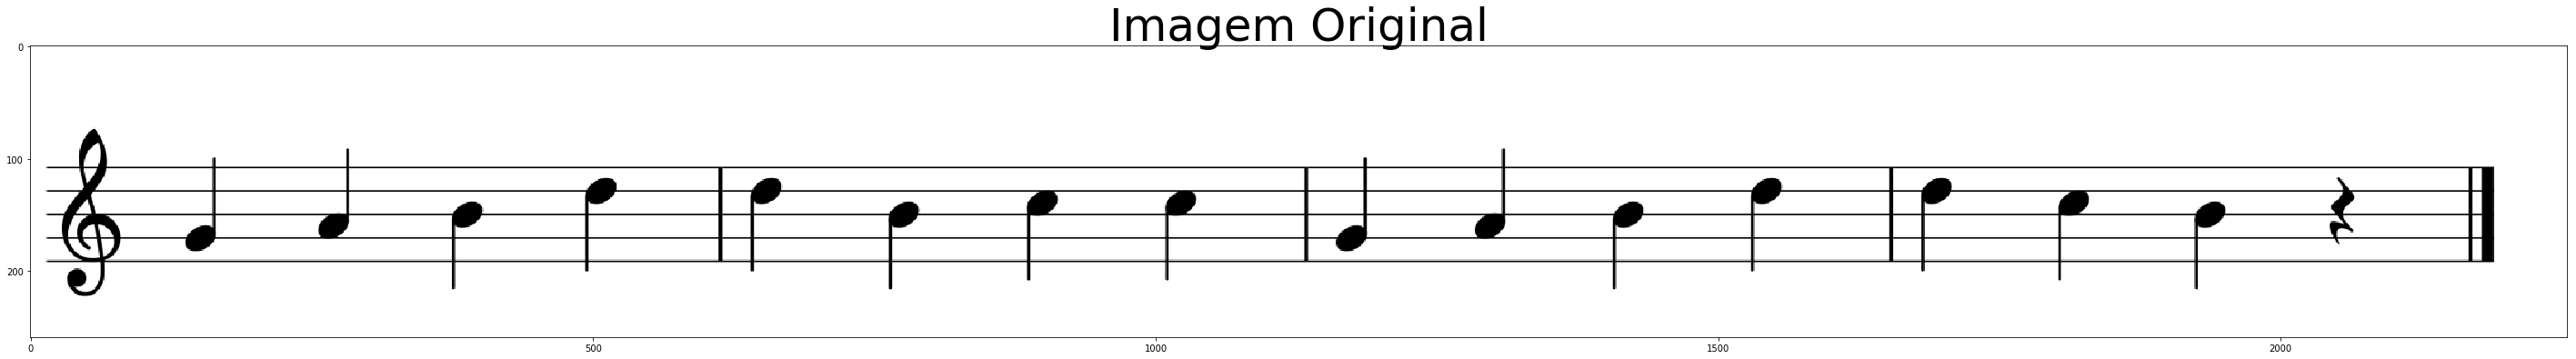

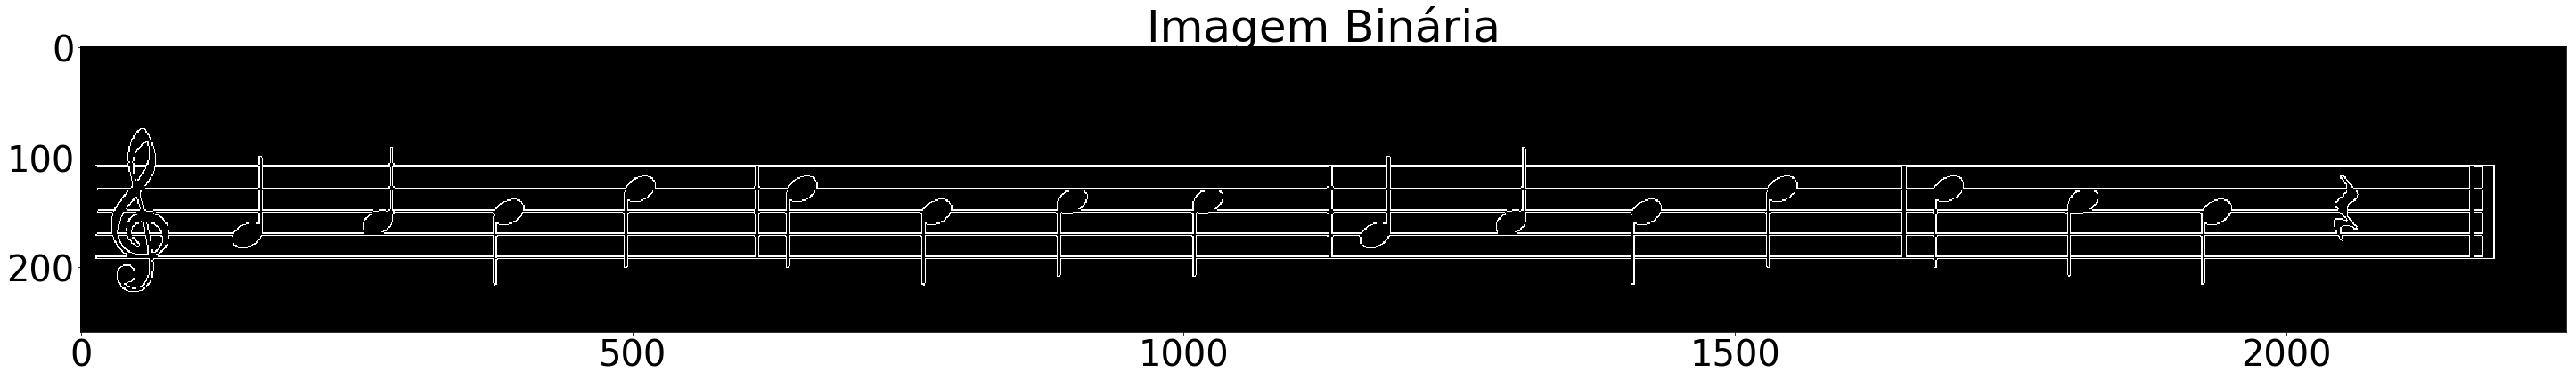

In [6]:
grayImage = graycolor(image)
binaryImage = binarize(image)
display(image,'Imagem Original')
display(binaryImage,'Imagem Binária', gray=1)

## 2. Segmentação:

In [7]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (11,11), 0)
edged = cv2.Canny(blur, 0, 50) 

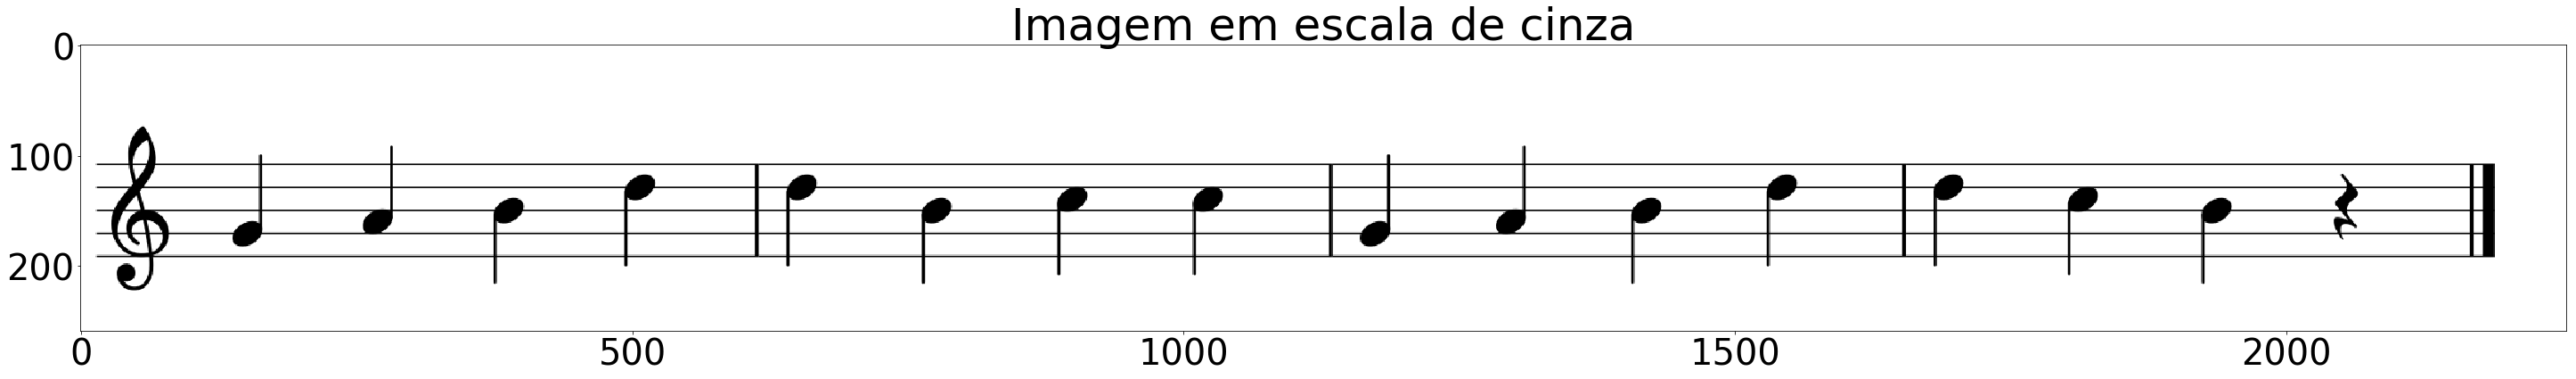

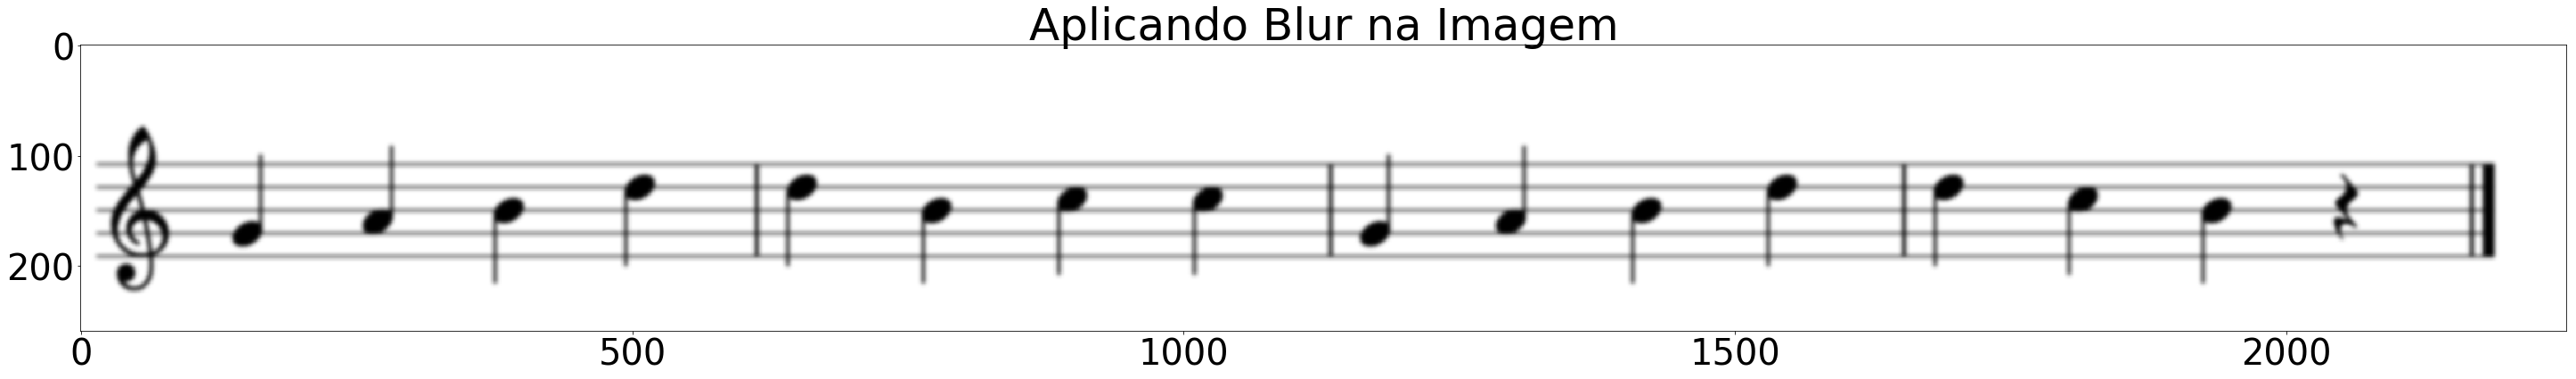

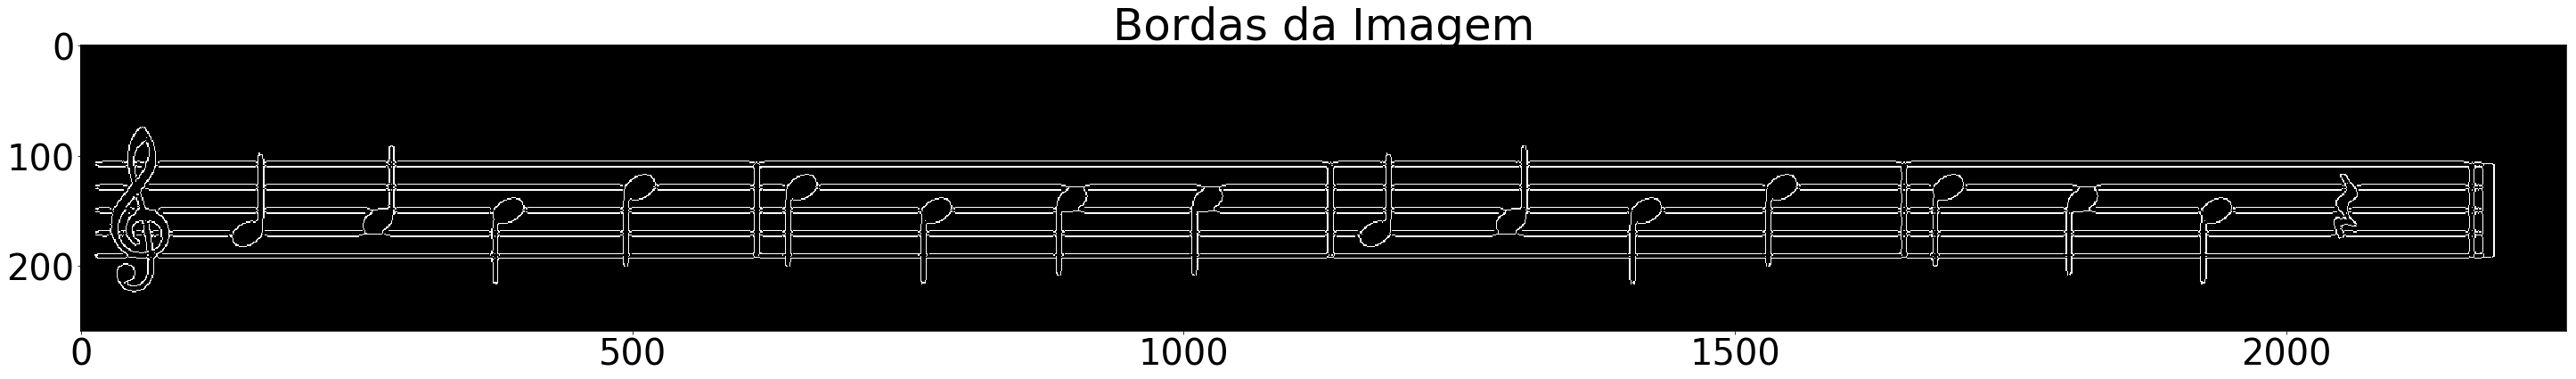

In [8]:
display(gray,'Imagem em escala de cinza',gray=1)
display(blur,'Aplicando Blur na Imagem',gray=1)
display(edged,'Bordas da Imagem',gray=1)

In [9]:
lines = cv2.HoughLines(edged, 1, np.pi / 150, 200)
imagem_com_cor = cv2.cvtColor(edged, cv2.COLOR_GRAY2BGR)
img = image
width = image.shape[0]
height = image.shape[1]
nlines = 80

all_lines = set()

for result_arr in lines[:nlines]:
    rho = result_arr[0][0]
    theta = result_arr[0][1]
    a = np.cos(theta)
    b = np.sin(theta)

    x0 = a * rho
    y0 = b * rho
    shape_sum = width + height
    x1 = int(x0 + shape_sum * (-b))
    y1 = int(y0 + shape_sum * a)
    x2 = int(x0 - shape_sum * (-b))
    y2 = int(y0 - shape_sum * a)

    start = (x1, y1)
    end = (x2, y2)
    diff = y2 - y1
    if abs(diff) < LINES_ENDPOINTS_DIFFERENCE:
        all_lines.add(int((start[1] + end[1]) / 2))
        cv2.line(imagem_com_cor, start, end, (0, 0, 255), 2)

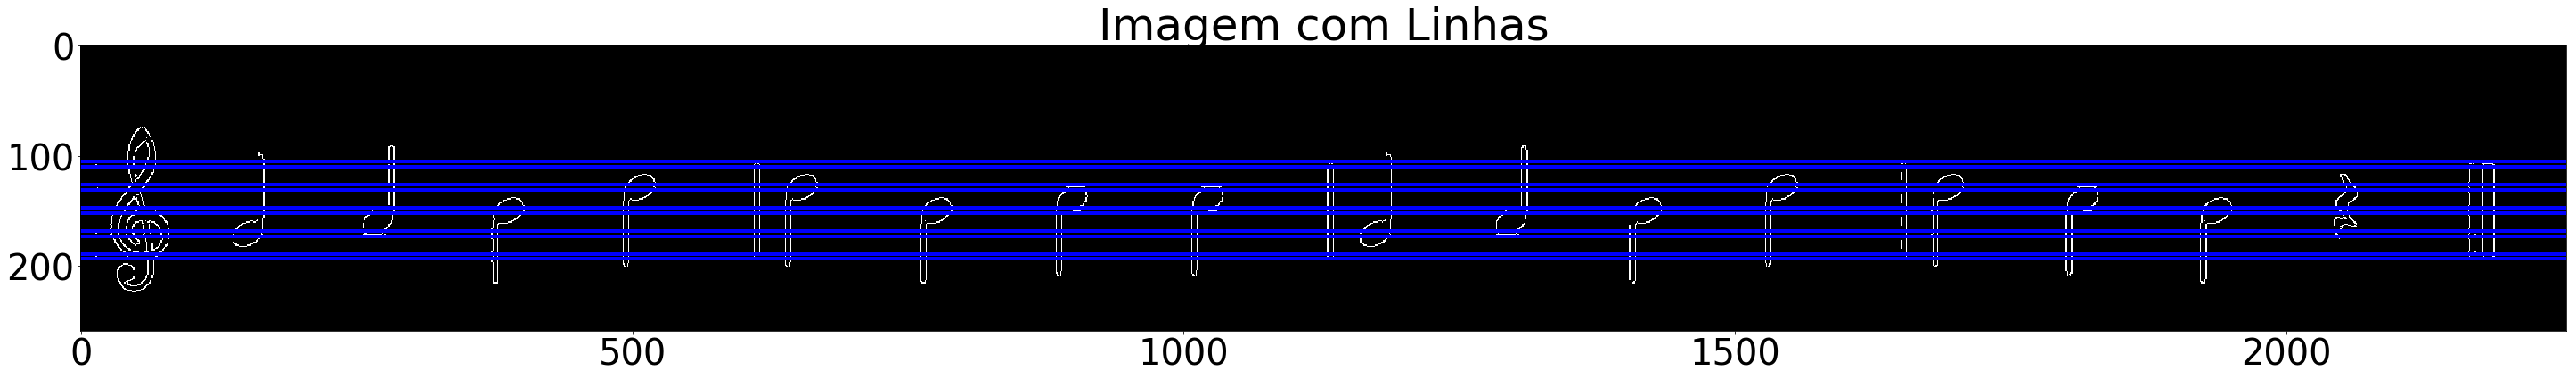

In [10]:
display(imagem_com_cor,'Imagem com Linhas',gray=0)

## 3.Removendo as linhas da "music sheet"

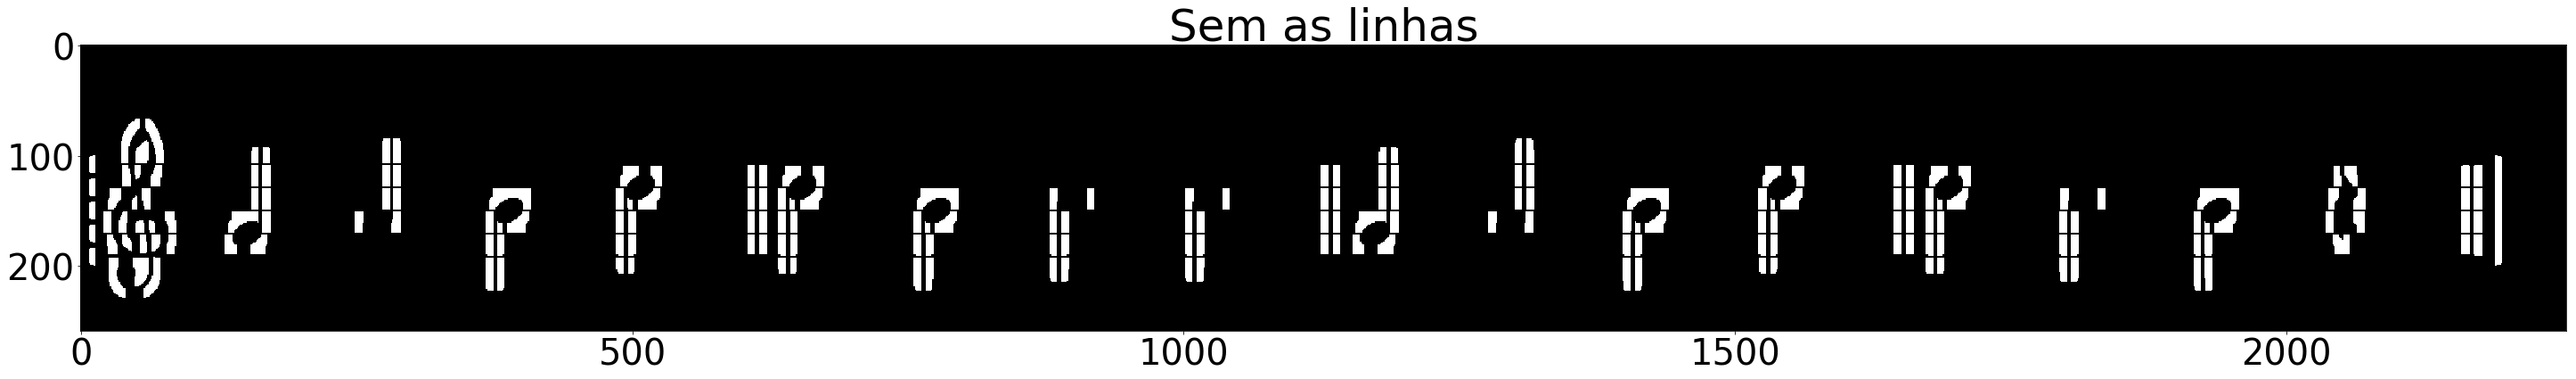

In [11]:
    gray2 = cv2.bitwise_not(grayImage)
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
                                cv2.THRESH_BINARY, 15, -2)
    vertical = np.copy(bw)
    rows = vertical.shape[0]
    verticalsize = round(rows / 30)
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
    vertical = cv2.erode(vertical, verticalStructure)
    vertical = cv2.dilate(vertical, verticalStructure)

    display(vertical,"Sem as linhas",gray = 1)


## 4. Refinando a imagem obtida

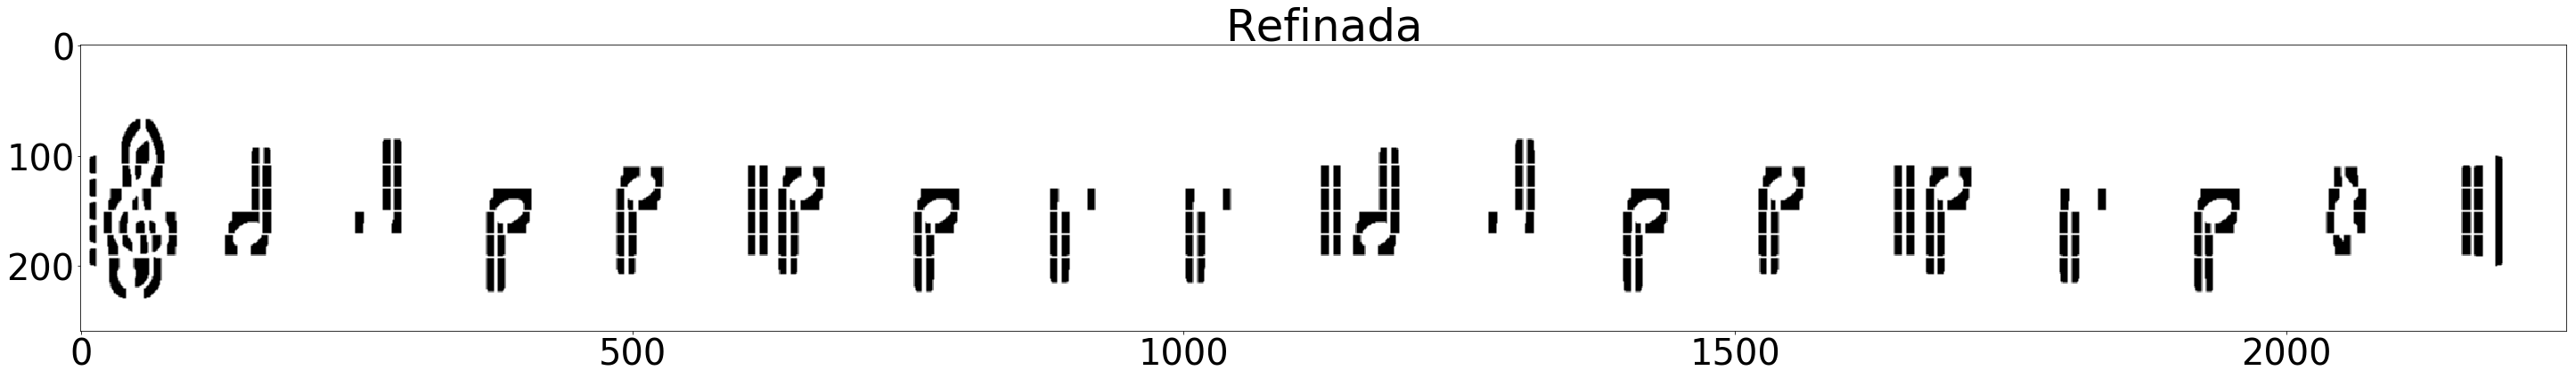

In [12]:
    vertical = cv2.bitwise_not(vertical)
    edges = cv2.adaptiveThreshold(vertical, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
                                cv2.THRESH_BINARY, 3, -2)
    kernel = np.ones((2, 2), np.uint8)
    edges = cv2.dilate(edges, kernel)
    smooth = np.copy(vertical)
    smooth = cv2.blur(smooth, (2, 2))
    (rows, cols) = np.where(edges != 0)
    vertical[rows, cols] = smooth[rows, cols]
    display(vertical,"Refinada",gray = 1)

ola
ola ola ola


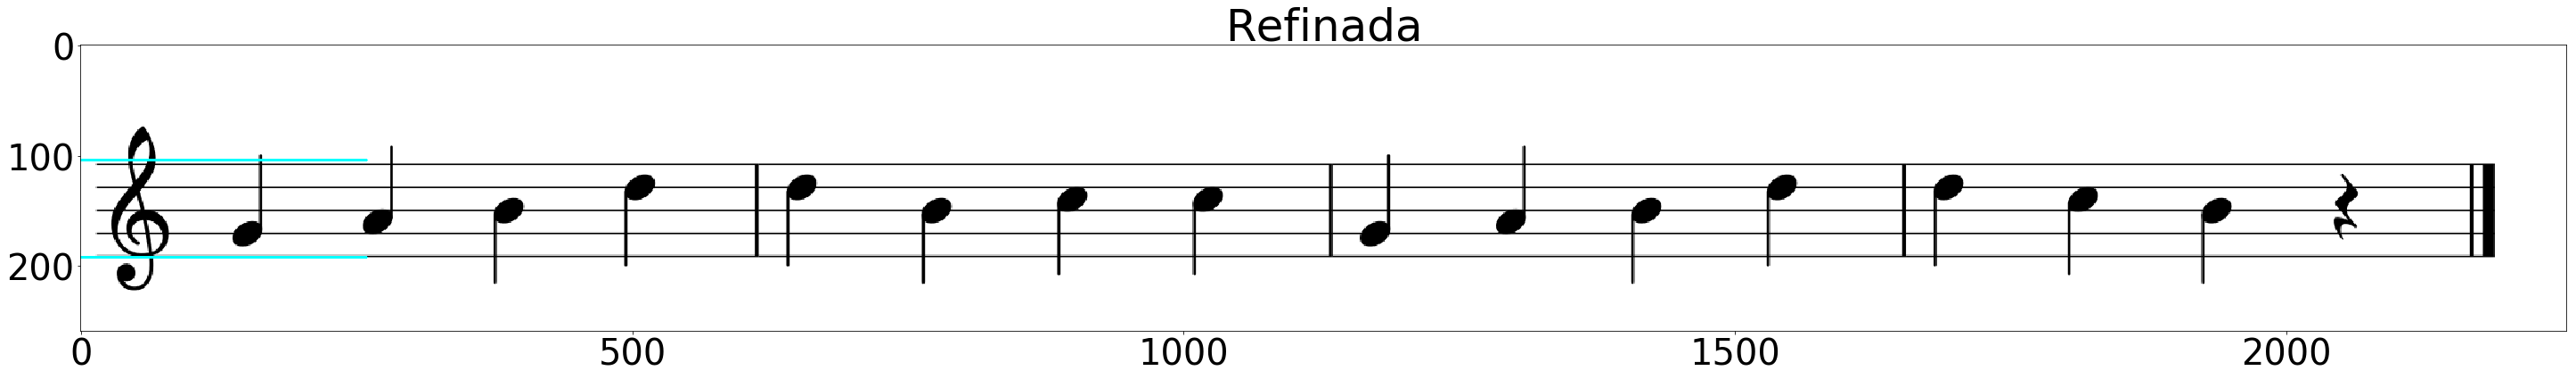

(104, 192, 188)

In [13]:
    staffs = []
    lines = []
    all_lines = sorted(all_lines)
    for current_line in all_lines:
        # If current line is far away from last detected line
        if lines and abs(lines[-1] - current_line) > LINES_DISTANCE_THRESHOLD:
            if len(lines) >= 5:
                # Consider it the start of the next staff.
                # If <5 - not enough lines detected. Probably an anomaly - reject.
                staffs.append((lines[0], lines[-1]))
            lines.clear()
        lines.append(current_line)

    # Process the last line
    if len(lines) >= 5:
        print("ola")
        if abs(lines[-2] - lines[-1]) <= LINES_DISTANCE_THRESHOLD:
            print("ola ola ola")
            staffs.append((lines[0], lines[-1], lines[-2]))
    width = image.shape[0]
    for staff in staffs:
        cv2.line(image, (0, staff[0]), (width, staff[0]), (0, 255, 255), 2)
        cv2.line(image, (0, staff[1]), (width, staff[1]), (0, 255, 255), 2)            
    display(image,"Refinada")
    staff
    

Estimated size of the staff lines =  1997.0
Estimade number of staves =  1


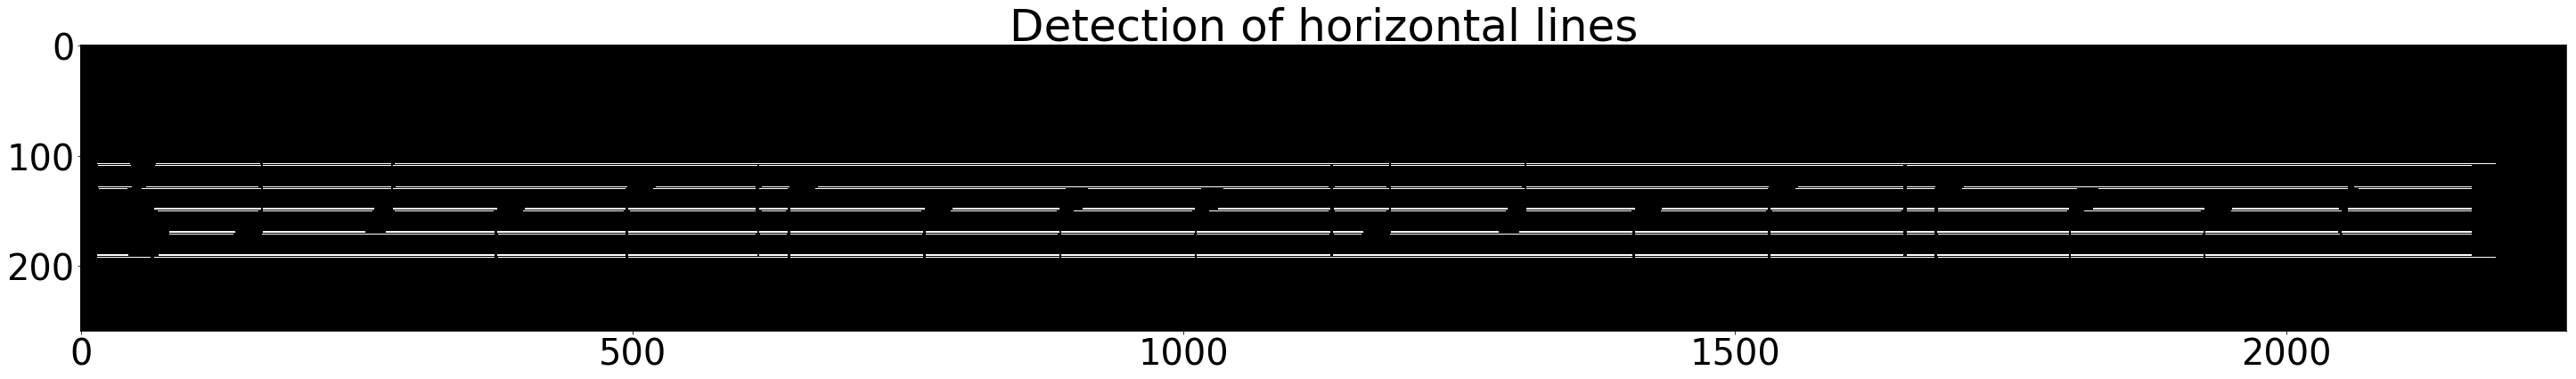

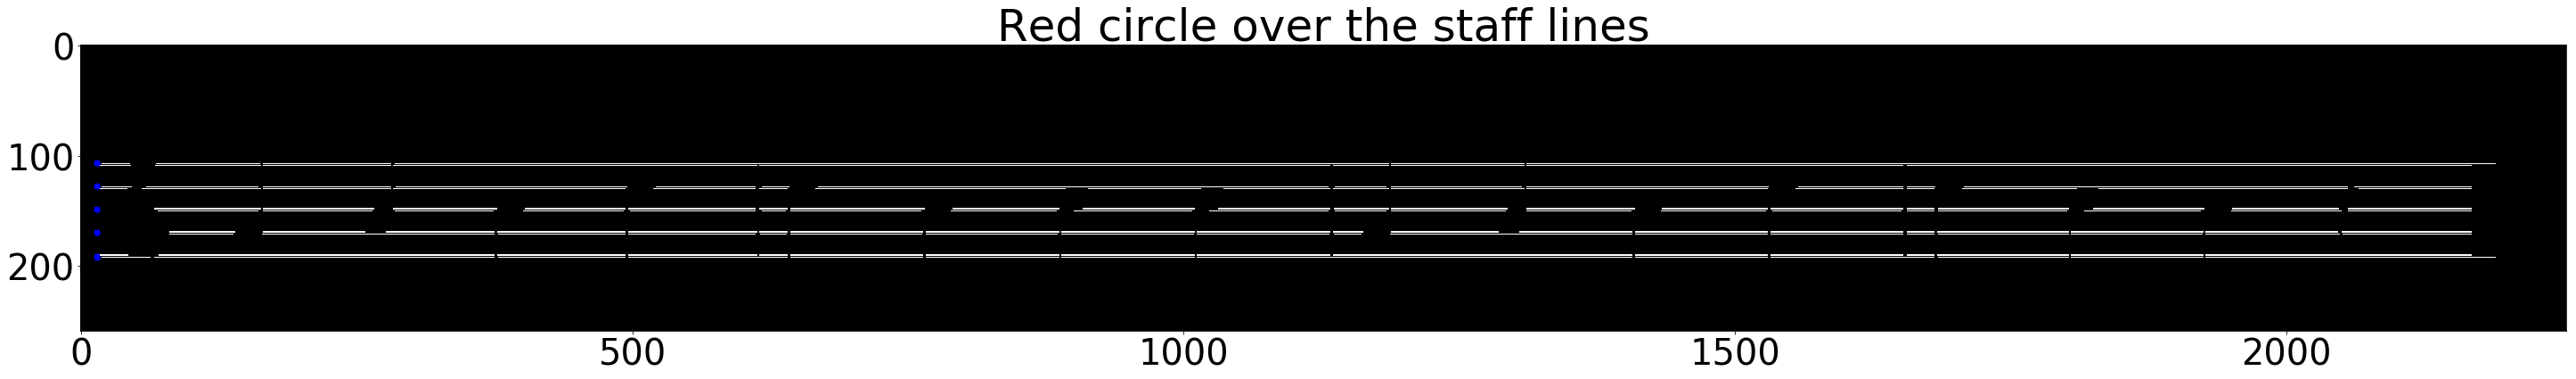

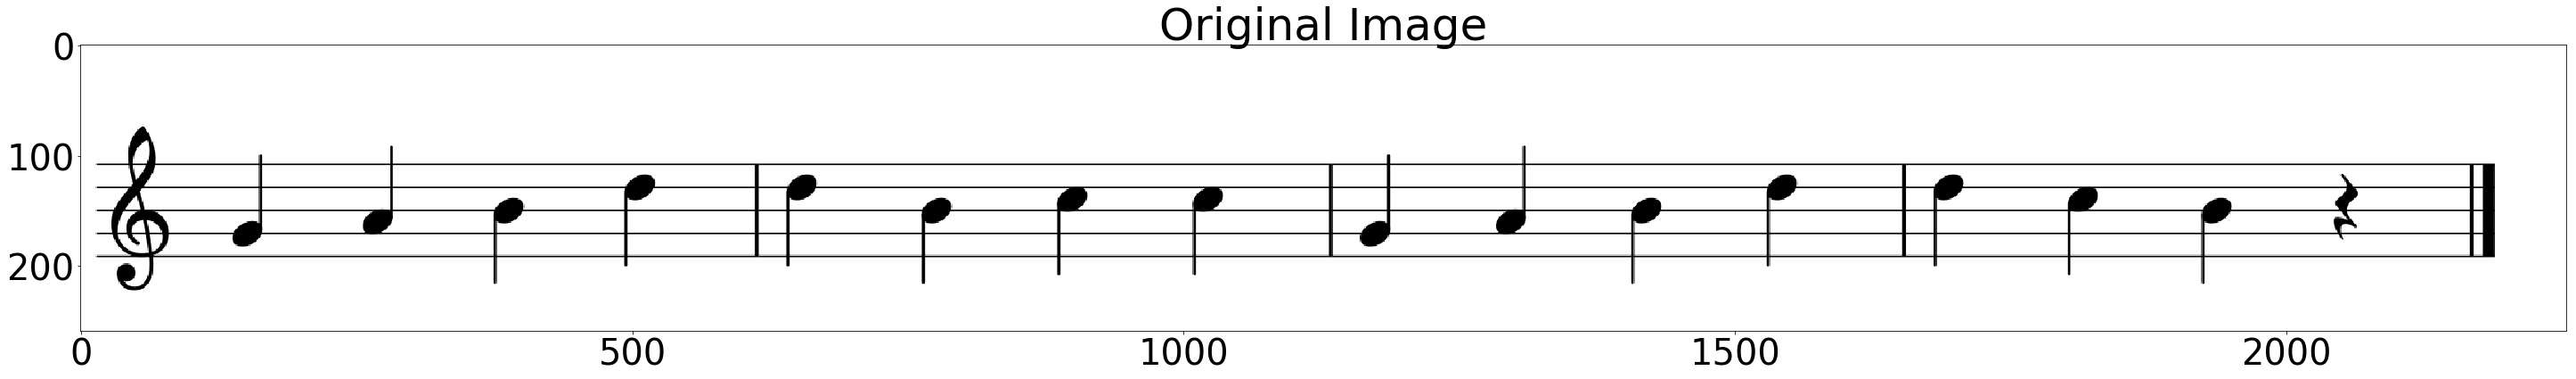

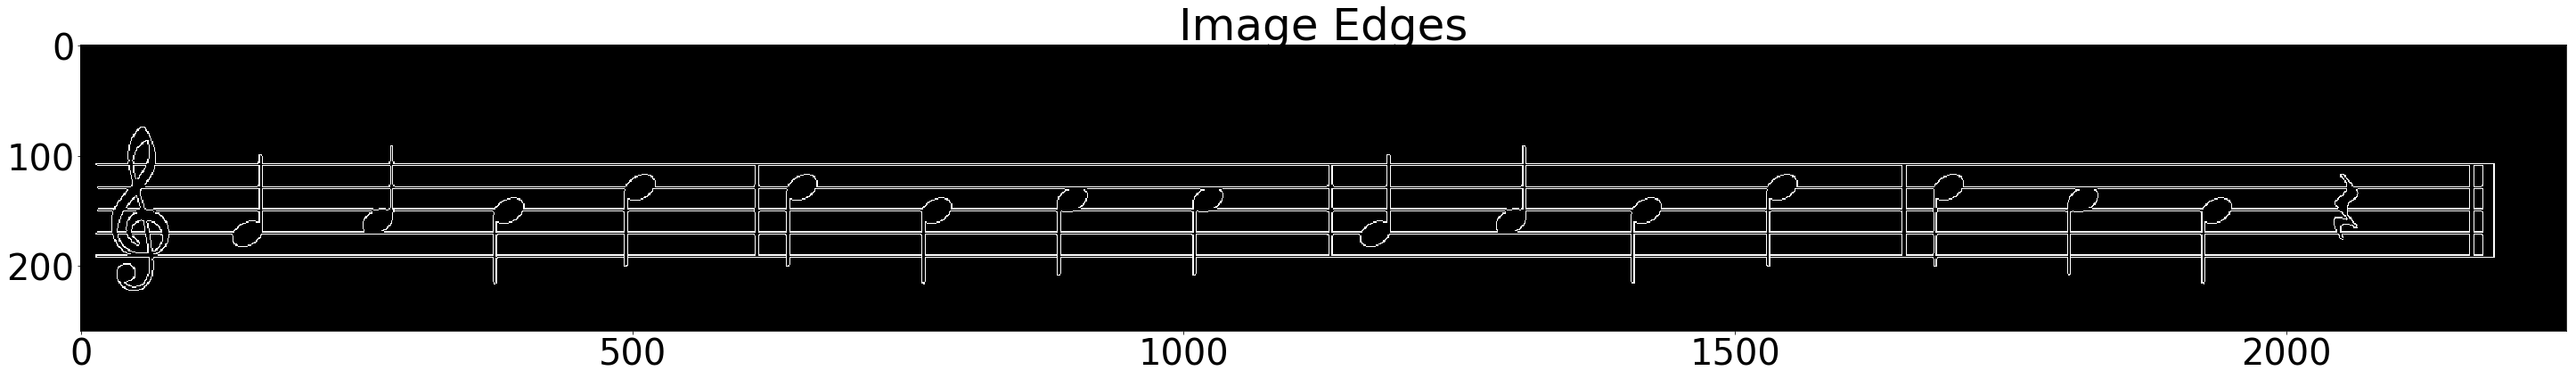

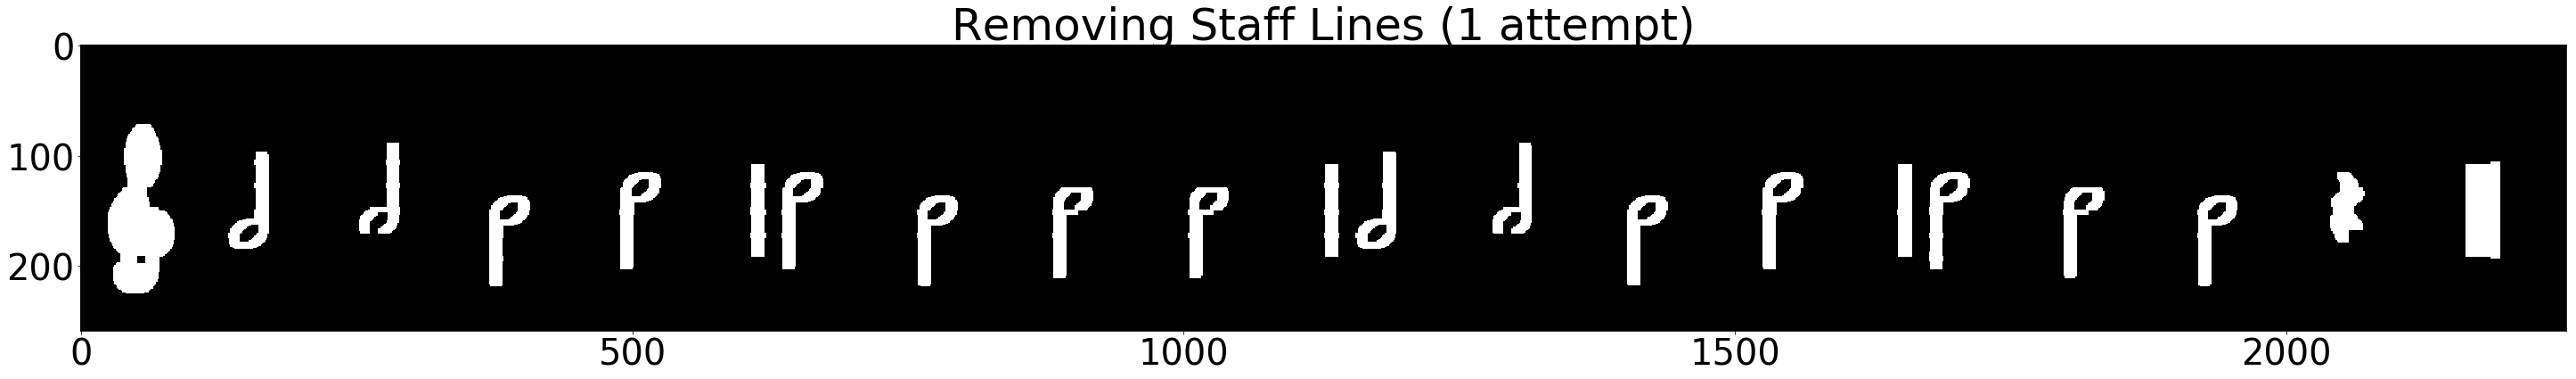

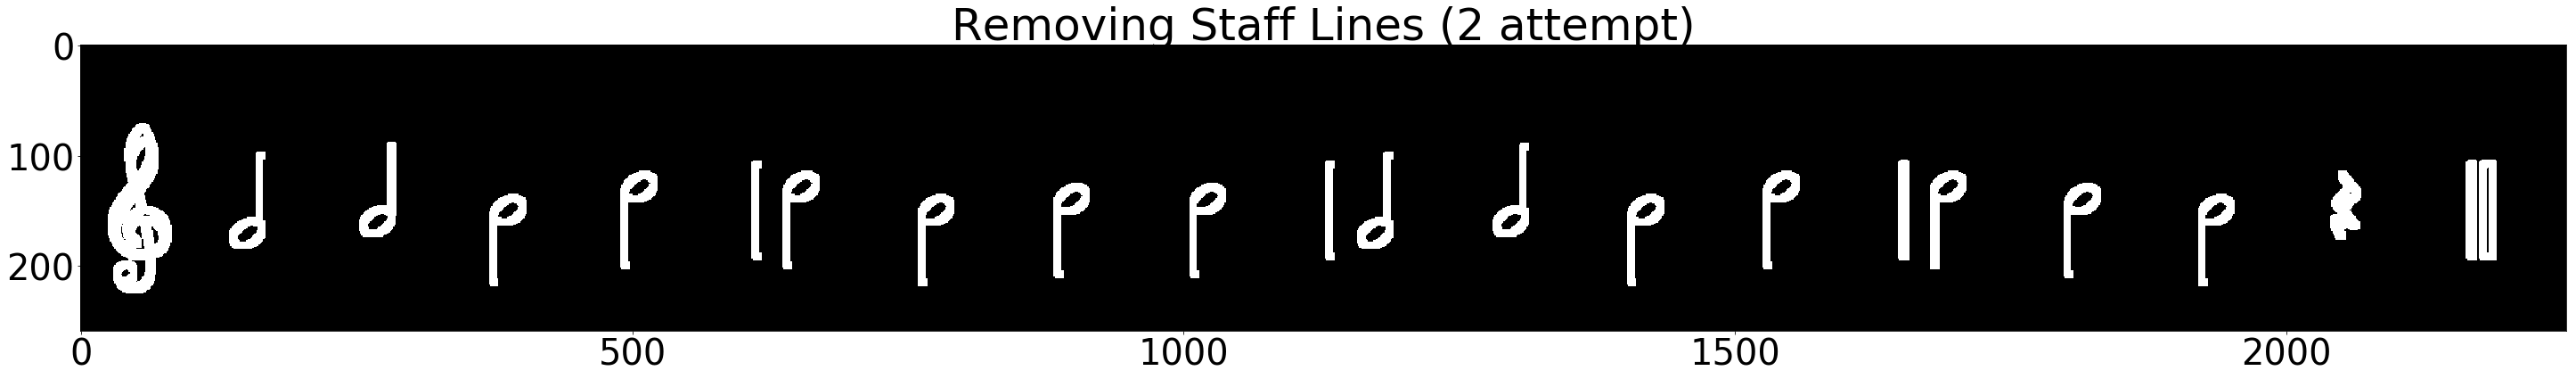

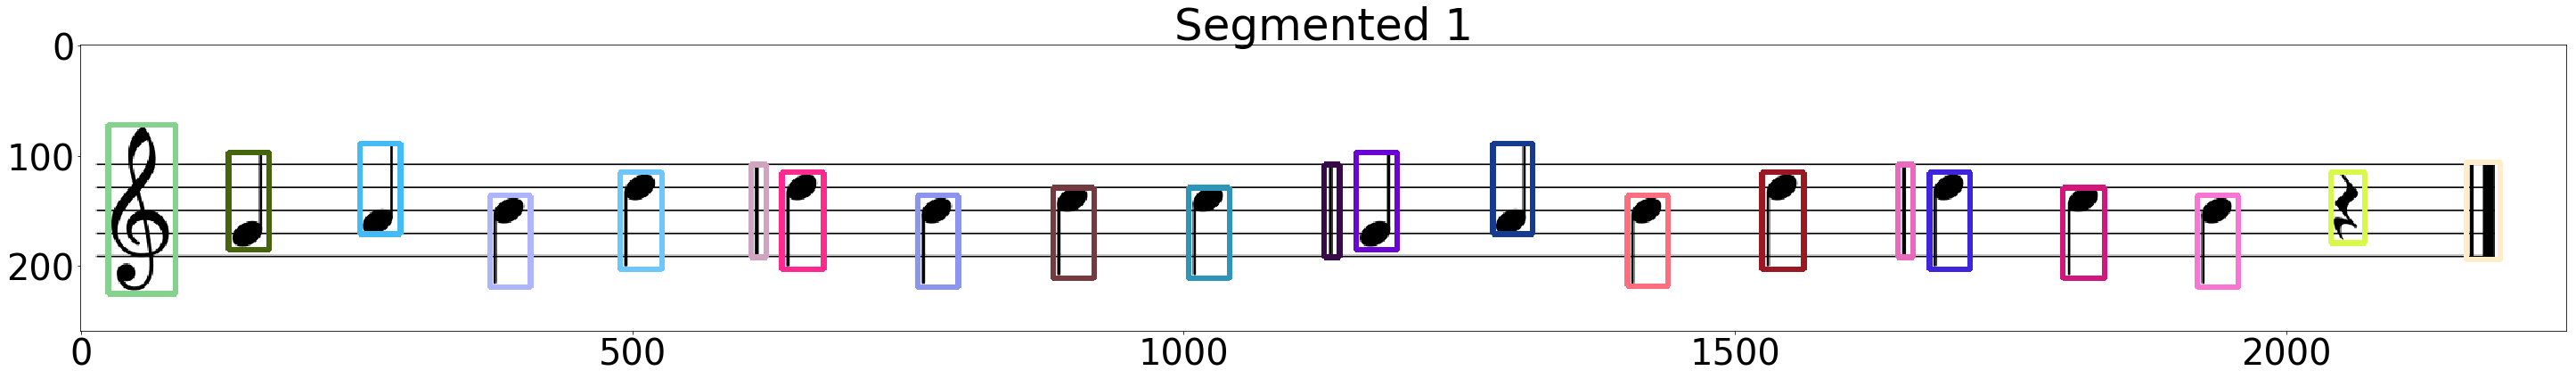

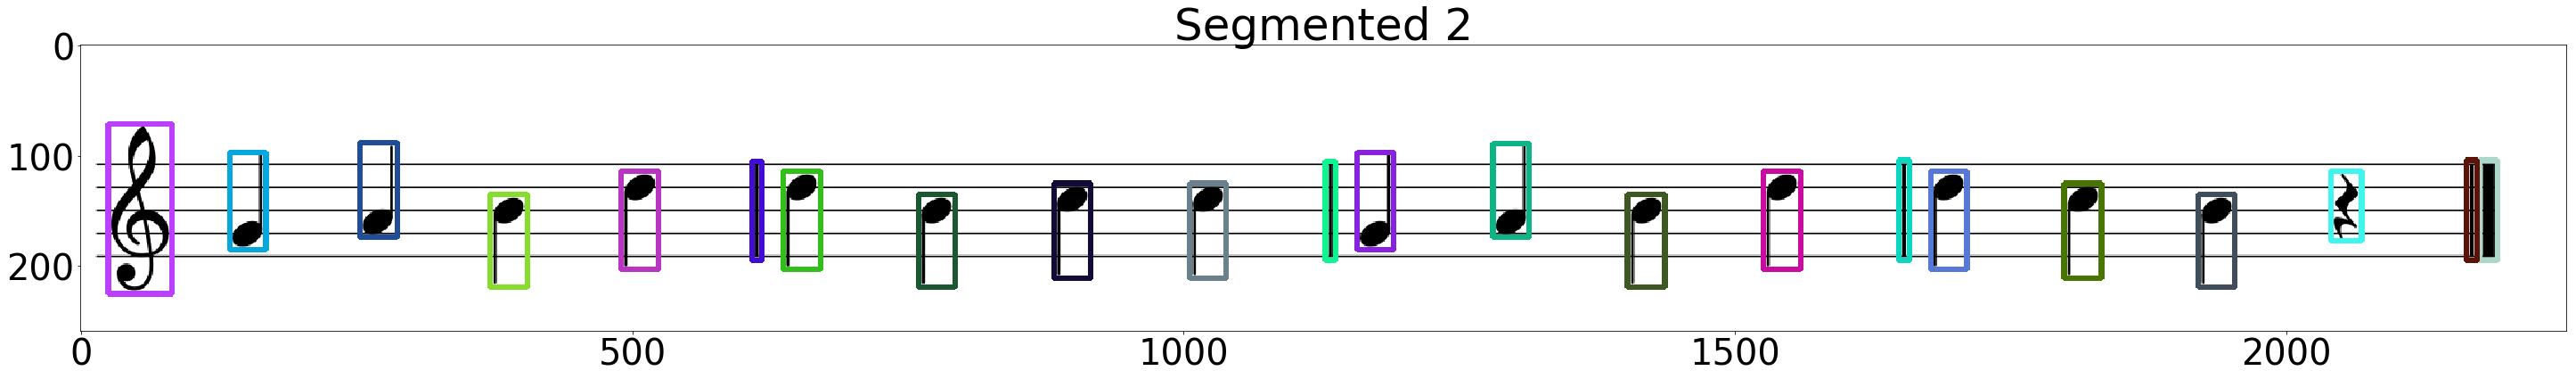

[[1921, 135, 33, 84, None],
 [1403, 135, 34, 84, None],
 [760, 135, 33, 84, None],
 [371, 135, 34, 84, None],
 [1799, 125, 34, 86, None],
 [1006, 125, 33, 86, None],
 [883, 125, 33, 86, None],
 [2041, 114, 28, 63, None],
 [1678, 114, 33, 89, None],
 [1526, 114, 34, 89, None],
 [637, 114, 34, 89, None],
 [490, 114, 34, 89, None],
 [1129, 105, 9, 90, None],
 [609, 105, 9, 90, None],
 [2176, 104, 16, 91, None],
 [2164, 104, 10, 91, None],
 [1649, 104, 10, 91, None],
 [1158, 97, 33, 88, None],
 [135, 97, 33, 88, None],
 [1281, 89, 33, 85, None],
 [253, 88, 34, 86, None],
 [25, 71, 58, 154, None]]

In [20]:
""" Fluxo principal """
path = "data/1.png"
img = cv2.imread(path)				#Carrega a imagem, designada pelo argumento 1 passado via linha de comando
grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)	#Converte a imagem do espaço de cores BGR para tons de cinza
binImg = binarize(grayImg)						#Binariza a imagem em tons de cinza

h, w = img.shape[:2]

staves, D = detectStaffLines(binImg.copy())	#detecta onde começam as linhas de pauta
binImg3 = removeStaffLines(binImg.copy(), staves[0][0][0])		#remove as linhas de pauta
binImg2 = removeStaffLines2(grayImg.copy())		#remove as linhas de pauta

cv2.namedWindow("Original Image", cv2.WINDOW_NORMAL)        	#Cria uma janela nomeada que pode ser redimensionada
cv2.namedWindow("Image Edges", cv2.WINDOW_NORMAL)  		#Cria uma janela nomeada que pode ser redimensionada
cv2.namedWindow("Removing Staff Lines (1 attempt)", cv2.WINDOW_NORMAL)  		#Cria uma janela nomeada que pode ser redimensionada
cv2.namedWindow("Removing Staff Lines (2 attempt)", cv2.WINDOW_NORMAL)  		#Cria uma janela nomeada que pode ser redimensionada
display(img,"Original Image")                              	#Exibe imagem original em BGR
display( binImg,"Image Edges", gray = 1)                 			#Exibe as bordas da imagem
display(binImg3,"Removing Staff Lines (1 attempt)",gray = 1)                 			#Exibe as bordas da imagem
display( binImg2,"Removing Staff Lines (2 attempt)", gray = 1)                 			#Exibe as bordas da imagem
segment(binImg3, img.copy(), 1)
segment(binImg2, img.copy(), 2)